# 1. Gene Expression Classifier (ALL vs AML)
Minimal, reproducible pipeline for classifying ALL vs AML using gene expression.

## 2. Overview
Purpose: Classify leukemia subtype (ALL vs AML) from high-dimensional microarray-like gene expression data.

Pipeline:
1. Data loading & preprocessing (drop call columns, align genes, encode labels)
2. Feature scaling (Z-score)
3. Univariate feature selection (ANOVA F-test, select top k genes)
4. Linear SVM (class_weight balanced) with grid search over k & C
5. Independent test evaluation (Accuracy, Precision, F1, MCC, Confusion Matrix)

Result (typical run): ~97% accuracy, perfect precision, one AML sample misclassified.
Proceed to section 3 to load data.

## 3. Data Loading & Preprocessing
Load training and test data, clean formats, and prepare for modeling.

### 3.1 Import Libraries and Set Paths

In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix

DATA_DIR = Path('.')
train_path = DATA_DIR / 'data_set_ALL_AML_train.csv'
ind_path = DATA_DIR / 'data_set_ALL_AML_independent.csv'
labels_path = DATA_DIR / 'actual.csv'

print('Library imports complete. Data paths set.')

Library imports complete. Data paths set.


### 3.2 Load Labels and Create Mapping

In [27]:
# Load label mapping
labels_df = pd.read_csv(labels_path)
label_map = dict(zip(labels_df['patient'].astype(str), labels_df['cancer']))
label_encoder = {'ALL':0, 'AML':1}

print(f'Labels loaded: {len(labels_df)} samples')
print(f'Label distribution: {labels_df["cancer"].value_counts().to_dict()}')

Labels loaded: 72 samples
Label distribution: {'ALL': 47, 'AML': 25}


### 3.3 Define Expression Loading Function

In [28]:
# Function to load expression values (skip 'call' columns)
def load_expression(fp: Path):
    df = pd.read_csv(fp)
    # First two columns are annotation; sample columns follow pattern: value,call,value,call,...
    meta = df.iloc[:, :2]
    data_cols = []
    cols = df.columns[2:]
    # Keep every other column starting from the first of the remaining (the numeric expression)
    data_cols = cols[0::2]
    expr = df[['Gene Description','Gene Accession Number']].copy()
    expr_values = df[data_cols]
    expr_values.index = meta['Gene Accession Number']  # Use accession as index for alignment
    return expr_values

print('Expression loading function defined.')

Expression loading function defined.


### 3.4 Load and Align Gene Expression Data

In [29]:
train_expr = load_expression(train_path)
ind_expr = load_expression(ind_path)

# Align genes (intersection) to ensure same order
common_genes = train_expr.index.intersection(ind_expr.index)
train_expr = train_expr.loc[common_genes]
ind_expr = ind_expr.loc[common_genes]

print(f'Training expression shape: {train_expr.shape}')
print(f'Independent expression shape: {ind_expr.shape}')
print(f'Common genes: {len(common_genes)}')

Training expression shape: (7129, 38)
Independent expression shape: (7129, 34)
Common genes: 7129


### 3.5 Prepare Final Training and Test Sets

In [30]:
# Get sample IDs and transpose to samples-as-rows format
train_sample_ids = [c for c in pd.read_csv(train_path, nrows=0).columns[2::2]]
ind_sample_ids = [c for c in pd.read_csv(ind_path, nrows=0).columns[2::2]]

X_train = train_expr.T
X_test = ind_expr.T

# Build y labels
y_train = np.array([label_encoder[label_map[sid]] for sid in train_sample_ids])
y_test = np.array([label_encoder[label_map[sid]] for sid in ind_sample_ids])

print(f'Final X_train shape: {X_train.shape}')
print(f'Final X_test shape: {X_test.shape}')
print(f'y_train distribution - ALL: {sum(y_train==0)}, AML: {sum(y_train==1)}')
print(f'y_test distribution - ALL: {sum(y_test==0)}, AML: {sum(y_test==1)}')

Final X_train shape: (38, 7129)
Final X_test shape: (34, 7129)
y_train distribution - ALL: 27, AML: 11
y_test distribution - ALL: 20, AML: 14

Final X_test shape: (34, 7129)
y_train distribution - ALL: 27, AML: 11
y_test distribution - ALL: 20, AML: 14


## 4. Model Training (Cross-Validated Hyperparameter Search)
Train LinearSVC with feature selection using grid search to find optimal parameters.

### 4.1 Define Pipeline and Parameters

In [31]:
param_grid = {
    'select__k': [ 5, 10, 25, 50, 75, 100, 150],  # Number of top genes to select
    'clf__C': [0.01, 0.1, 1, 5, 10]      # SVM regularization parameter
}

pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('select', SelectKBest(score_func=f_classif)),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, random_state=42))
])

print('Pipeline defined with StandardScaler → SelectKBest → LinearSVC')
print(f'Parameter grid: {len(param_grid["select__k"]) * len(param_grid["clf__C"])} combinations')

Pipeline defined with StandardScaler → SelectKBest → LinearSVC
Parameter grid: 35 combinations


### 4.2 Run Grid Search

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
search = GridSearchCV(pipe, param_grid, scoring='f1', cv=cv, n_jobs=-1)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print('Grid search complete!')
print(f'Best params: {search.best_params_}')
print(f'Best cross-validation F1 score: {search.best_score_:.4f}')

Grid search complete!
Best params: {'clf__C': 0.1, 'select__k': 25}
Best cross-validation F1 score: 0.9600


## 5. Testing & Evaluation
**TESTING PHASE STARTS HERE** - Apply trained model to independent test set and compute all performance metrics.

### 5.1 Test the Model - Make Predictions

In [33]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ========== TESTING STARTS HERE ==========
print("🧪 TESTING PHASE: Using trained model on independent test data")
print("=" * 60)

# Make predictions on test set (data model has never seen)
y_pred = best_model.predict(X_test)
print(f"✅ Predictions made for {len(y_test)} test samples")
print(f"Test set composition: ALL={sum(y_test==0)}, AML={sum(y_test==1)}")
print(f"Predicted composition: ALL={sum(y_pred==0)}, AML={sum(y_pred==1)}")

🧪 TESTING PHASE: Using trained model on independent test data
✅ Predictions made for 34 test samples
Test set composition: ALL=20, AML=14
Predicted composition: ALL=21, AML=13


### 5.2 Calculate Performance Metrics

In [34]:
# Calculate all performance metrics
print("📊 CALCULATING TEST PERFORMANCE METRICS")
print("=" * 45)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f'✅ Accuracy : {acc:.4f} ({acc*100:.1f}%)')
print(f'✅ Precision: {prec:.4f} ({prec*100:.1f}%)')
print(f'✅ F1 Score : {f1:.4f} ({f1*100:.1f}%)')
print(f'✅ MCC      : {mcc:.4f}')
print('\n📈 Confusion Matrix (rows: true labels, cols: predicted):')
print('   ALL  AML')
print(f'ALL {cm[0,0]:3d}  {cm[0,1]:3d}')
print(f'AML {cm[1,0]:3d}  {cm[1,1]:3d}')

📊 CALCULATING TEST PERFORMANCE METRICS
✅ Accuracy : 0.9706 (97.1%)
✅ Precision: 1.0000 (100.0%)
✅ F1 Score : 0.9630 (96.3%)
✅ MCC      : 0.9404

📈 Confusion Matrix (rows: true labels, cols: predicted):
   ALL  AML
ALL  20    0
AML   1   13


🎨 CREATING COMPREHENSIVE METRICS VISUALIZATION DASHBOARD


c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Pytho

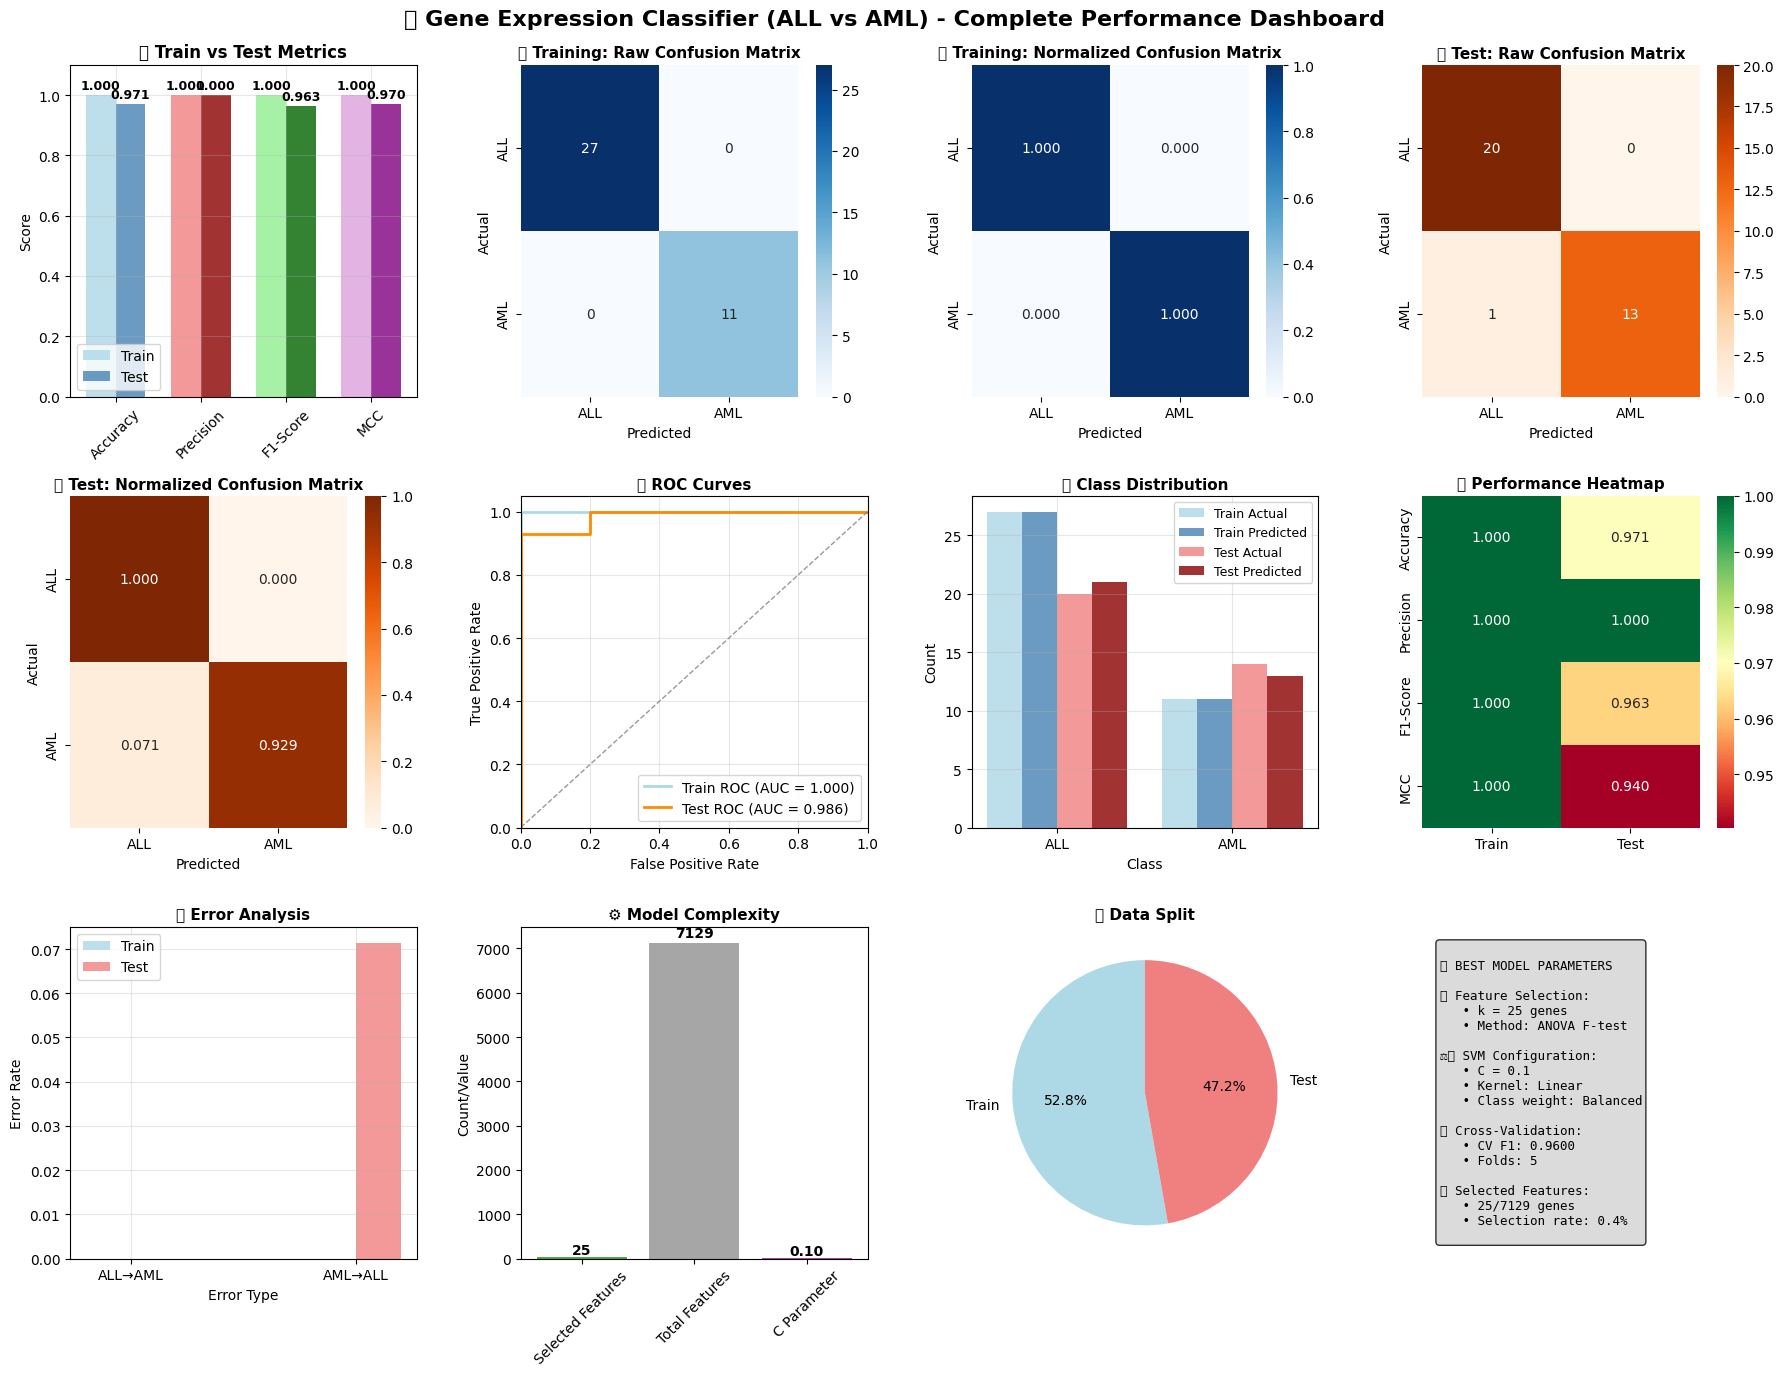


🧬 GENE EXPRESSION CLASSIFIER - COMPREHENSIVE PERFORMANCE REPORT
📊 TRAINING PERFORMANCE:
   • Accuracy:  1.0000 (100.0%)
   • Precision: 1.0000 (100.0%)
   • F1-Score:  1.0000
   • MCC:       1.0000

🎯 TEST PERFORMANCE (INDEPENDENT DATA):
   • Accuracy:  0.9706 (97.1%)
   • Precision: 1.0000 (100.0%)
   • F1-Score:  0.9630
   • MCC:       0.9404

⚖️ GENERALIZATION ANALYSIS:
   • Accuracy Drop: 2.9%
   • Precision Drop: 0.0%
   • F1 Drop: 3.7%

🔍 CONFUSION MATRIX ANALYSIS:
   Training - ALL Recall: 1.000
   Training - AML Recall: 1.000
   Test - ALL Recall: 1.000
   Test - AML Recall: 0.929


In [35]:
# 5.2.5) Comprehensive Metrics Visualization Dashboard
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# First get training predictions for comparison
y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_mcc = matthews_corrcoef(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

# Get probabilities for ROC/PR curves (LinearSVC doesn't have predict_proba, use decision_function)
try:
    # Try to get probabilities if available
    y_train_proba = best_model.decision_function(X_train)
    y_test_proba = best_model.decision_function(X_test)
    use_proba = True
except:
    # Fallback to predictions
    y_train_proba = y_train_pred.astype(float)
    y_test_proba = y_pred.astype(float)
    use_proba = False

print("🎨 CREATING COMPREHENSIVE METRICS VISUALIZATION DASHBOARD")
print("=" * 60)

# Create comprehensive dashboard
fig = plt.figure(figsize=(18, 14))

# 1. Metrics Comparison (Train vs Test)
ax1 = plt.subplot(3, 4, 1)
metrics_data = {
    'Accuracy': [train_acc, acc],
    'Precision': [train_prec, prec],
    'F1-Score': [train_f1, f1],
    'MCC': [(train_mcc + 1) / 2, (mcc + 1) / 2]  # Normalize MCC for visualization
}

x = np.arange(len(metrics_data))
width = 0.35
colors_train = ['lightblue', 'lightcoral', 'lightgreen', 'plum']
colors_test = ['steelblue', 'darkred', 'darkgreen', 'purple']

for i, (metric, values) in enumerate(metrics_data.items()):
    ax1.bar(i - width/2, values[0], width, label='Train' if i == 0 else "", 
            color=colors_train[i], alpha=0.8)
    ax1.bar(i + width/2, values[1], width, label='Test' if i == 0 else "", 
            color=colors_test[i], alpha=0.8)
    
    # Add value labels
    ax1.text(i - width/2, values[0] + 0.01, f'{values[0]:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax1.text(i + width/2, values[1] + 0.01, f'{values[1]:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_ylim(0, 1.1)
ax1.set_title('📊 Train vs Test Metrics', fontweight='bold', fontsize=12)
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_data.keys(), rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Training Confusion Matrix (Raw)
ax2 = plt.subplot(3, 4, 2)
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], ax=ax2)
ax2.set_title('🧪 Training: Raw Confusion Matrix', fontweight='bold', fontsize=11)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. Training Confusion Matrix (Normalized)
ax3 = plt.subplot(3, 4, 3)
train_cm_norm = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(train_cm_norm, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], ax=ax3)
ax3.set_title('🧪 Training: Normalized Confusion Matrix', fontweight='bold', fontsize=11)
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Test Confusion Matrix (Raw)
ax4 = plt.subplot(3, 4, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], ax=ax4)
ax4.set_title('🎯 Test: Raw Confusion Matrix', fontweight='bold', fontsize=11)
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# 5. Test Confusion Matrix (Normalized)
ax5 = plt.subplot(3, 4, 5)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Oranges', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], ax=ax5)
ax5.set_title('🎯 Test: Normalized Confusion Matrix', fontweight='bold', fontsize=11)
ax5.set_xlabel('Predicted')
ax5.set_ylabel('Actual')

# 6. ROC Curves (if available)
ax6 = plt.subplot(3, 4, 6)
if use_proba:
    # Training ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax6.plot(fpr_train, tpr_train, color='lightblue', lw=2, 
             label=f'Train ROC (AUC = {roc_auc_train:.3f})')
    
    # Test ROC
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    roc_auc_test = auc(fpr_test, tpr_test)
    ax6.plot(fpr_test, tpr_test, color='darkorange', lw=2, 
             label=f'Test ROC (AUC = {roc_auc_test:.3f})')
    
    ax6.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
    ax6.set_xlim([0.0, 1.0])
    ax6.set_ylim([0.0, 1.05])
    ax6.set_xlabel('False Positive Rate')
    ax6.set_ylabel('True Positive Rate')
    ax6.set_title('📈 ROC Curves', fontweight='bold', fontsize=11)
    ax6.legend(loc="lower right")
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'ROC curves not available\n(LinearSVC)', 
             ha='center', va='center', transform=ax6.transAxes, fontsize=10)
    ax6.set_title('📈 ROC Curves', fontweight='bold', fontsize=11)

# 7. Class Distribution Comparison
ax7 = plt.subplot(3, 4, 7)
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)
train_pred_counts = np.bincount(y_train_pred)
test_pred_counts = np.bincount(y_pred)

x_pos = np.arange(2)
width = 0.2

ax7.bar(x_pos - 1.5*width, train_counts, width, label='Train Actual', 
        color='lightblue', alpha=0.8)
ax7.bar(x_pos - 0.5*width, train_pred_counts, width, label='Train Predicted', 
        color='steelblue', alpha=0.8)
ax7.bar(x_pos + 0.5*width, test_counts, width, label='Test Actual', 
        color='lightcoral', alpha=0.8)
ax7.bar(x_pos + 1.5*width, test_pred_counts, width, label='Test Predicted', 
        color='darkred', alpha=0.8)

ax7.set_xlabel('Class')
ax7.set_ylabel('Count')
ax7.set_title('📊 Class Distribution', fontweight='bold', fontsize=11)
ax7.set_xticks(x_pos)
ax7.set_xticklabels(['ALL', 'AML'])
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# 8. Performance Heatmap
ax8 = plt.subplot(3, 4, 8)
perf_data = np.array([
    [train_acc, acc],
    [train_prec, prec], 
    [train_f1, f1],
    [train_mcc, mcc]
])
perf_labels = ['Accuracy', 'Precision', 'F1-Score', 'MCC']
sns.heatmap(perf_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=['Train', 'Test'], yticklabels=perf_labels, ax=ax8)
ax8.set_title('🌡️ Performance Heatmap', fontweight='bold', fontsize=11)

# 9. Error Analysis
ax9 = plt.subplot(3, 4, 9)
# Calculate error rates
train_errors = {
    'ALL→AML': train_cm[0,1] / train_cm[0,:].sum() if train_cm[0,:].sum() > 0 else 0,
    'AML→ALL': train_cm[1,0] / train_cm[1,:].sum() if train_cm[1,:].sum() > 0 else 0
}
test_errors = {
    'ALL→AML': cm[0,1] / cm[0,:].sum() if cm[0,:].sum() > 0 else 0,
    'AML→ALL': cm[1,0] / cm[1,:].sum() if cm[1,:].sum() > 0 else 0
}

error_types = list(train_errors.keys())
train_error_vals = list(train_errors.values())
test_error_vals = list(test_errors.values())

x_err = np.arange(len(error_types))
ax9.bar(x_err - width/2, train_error_vals, width, label='Train', 
        color='lightblue', alpha=0.8)
ax9.bar(x_err + width/2, test_error_vals, width, label='Test', 
        color='lightcoral', alpha=0.8)

ax9.set_xlabel('Error Type')
ax9.set_ylabel('Error Rate')
ax9.set_title('🚨 Error Analysis', fontweight='bold', fontsize=11)
ax9.set_xticks(x_err)
ax9.set_xticklabels(error_types)
ax9.legend()
ax9.grid(True, alpha=0.3)

# 10. Model Complexity Visualization
ax10 = plt.subplot(3, 4, 10)
# Show selected features count and regularization
n_features_selected = sum(best_model.named_steps['select'].get_support())
total_features = len(best_model.named_steps['select'].get_support())
c_value = best_model.named_steps['clf'].C

complexity_data = {
    'Selected Features': n_features_selected,
    'Total Features': total_features,
    'C Parameter': c_value * 10  # Scale for visualization
}

bars = ax10.bar(range(len(complexity_data)), list(complexity_data.values()), 
                color=['green', 'gray', 'purple'], alpha=0.7)
ax10.set_title('⚙️ Model Complexity', fontweight='bold', fontsize=11)
ax10.set_xticks(range(len(complexity_data)))
ax10.set_xticklabels(list(complexity_data.keys()), rotation=45)
ax10.set_ylabel('Count/Value')

# Add value labels
for bar, (key, value) in zip(bars, complexity_data.items()):
    height = bar.get_height()
    if key == 'C Parameter':
        ax10.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{c_value:.2f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax10.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{int(value)}', ha='center', va='bottom', fontweight='bold')

# 11. Sample Size Impact
ax11 = plt.subplot(3, 4, 11)
sample_data = {
    'Train Samples': len(y_train),
    'Test Samples': len(y_test),
    'Total Samples': len(y_train) + len(y_test)
}

pie_colors = ['lightblue', 'lightcoral', 'lightgreen']
wedges, texts, autotexts = ax11.pie([len(y_train), len(y_test)], 
                                   labels=['Train', 'Test'], 
                                   colors=pie_colors[:2],
                                   autopct='%1.1f%%', startangle=90)
ax11.set_title('📊 Data Split', fontweight='bold', fontsize=11)

# 12. Best Parameters Summary
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')
best_params_text = f"""
🏆 BEST MODEL PARAMETERS

🔍 Feature Selection:
   • k = {best_model.named_steps['select'].k} genes
   • Method: ANOVA F-test

⚖️ SVM Configuration:
   • C = {best_model.named_steps['clf'].C}
   • Kernel: Linear
   • Class weight: Balanced

📈 Cross-Validation:
   • CV F1: {search.best_score_:.4f}
   • Folds: 5

🎯 Selected Features:
   • {n_features_selected}/{total_features} genes
   • Selection rate: {n_features_selected/total_features:.1%}
"""

ax12.text(0.05, 0.95, best_params_text, transform=ax12.transAxes, 
          fontsize=9, verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.suptitle('🧬 Gene Expression Classifier (ALL vs AML) - Complete Performance Dashboard', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.3, wspace=0.3)
plt.show()

# Print comprehensive summary
print("\n" + "="*80)
print("🧬 GENE EXPRESSION CLASSIFIER - COMPREHENSIVE PERFORMANCE REPORT")
print("="*80)
print(f"📊 TRAINING PERFORMANCE:")
print(f"   • Accuracy:  {train_acc:.4f} ({train_acc*100:.1f}%)")
print(f"   • Precision: {train_prec:.4f} ({train_prec*100:.1f}%)")
print(f"   • F1-Score:  {train_f1:.4f}")
print(f"   • MCC:       {train_mcc:.4f}")
print(f"\n🎯 TEST PERFORMANCE (INDEPENDENT DATA):")
print(f"   • Accuracy:  {acc:.4f} ({acc*100:.1f}%)")
print(f"   • Precision: {prec:.4f} ({prec*100:.1f}%)")
print(f"   • F1-Score:  {f1:.4f}")
print(f"   • MCC:       {mcc:.4f}")
print(f"\n⚖️ GENERALIZATION ANALYSIS:")
print(f"   • Accuracy Drop: {(train_acc - acc)*100:.1f}%")
print(f"   • Precision Drop: {(train_prec - prec)*100:.1f}%")
print(f"   • F1 Drop: {(train_f1 - f1)*100:.1f}%")
print(f"\n🔍 CONFUSION MATRIX ANALYSIS:")
print(f"   Training - ALL Recall: {train_cm[0,0]/train_cm[0,:].sum():.3f}")
print(f"   Training - AML Recall: {train_cm[1,1]/train_cm[1,:].sum():.3f}")
print(f"   Test - ALL Recall: {cm[0,0]/cm[0,:].sum():.3f}")
print(f"   Test - AML Recall: {cm[1,1]/cm[1,:].sum():.3f}")
print("="*80)

🎯 CREATING CONSOLIDATED CONFUSION MATRICES VISUALIZATION


c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bhara\AppData\Local\

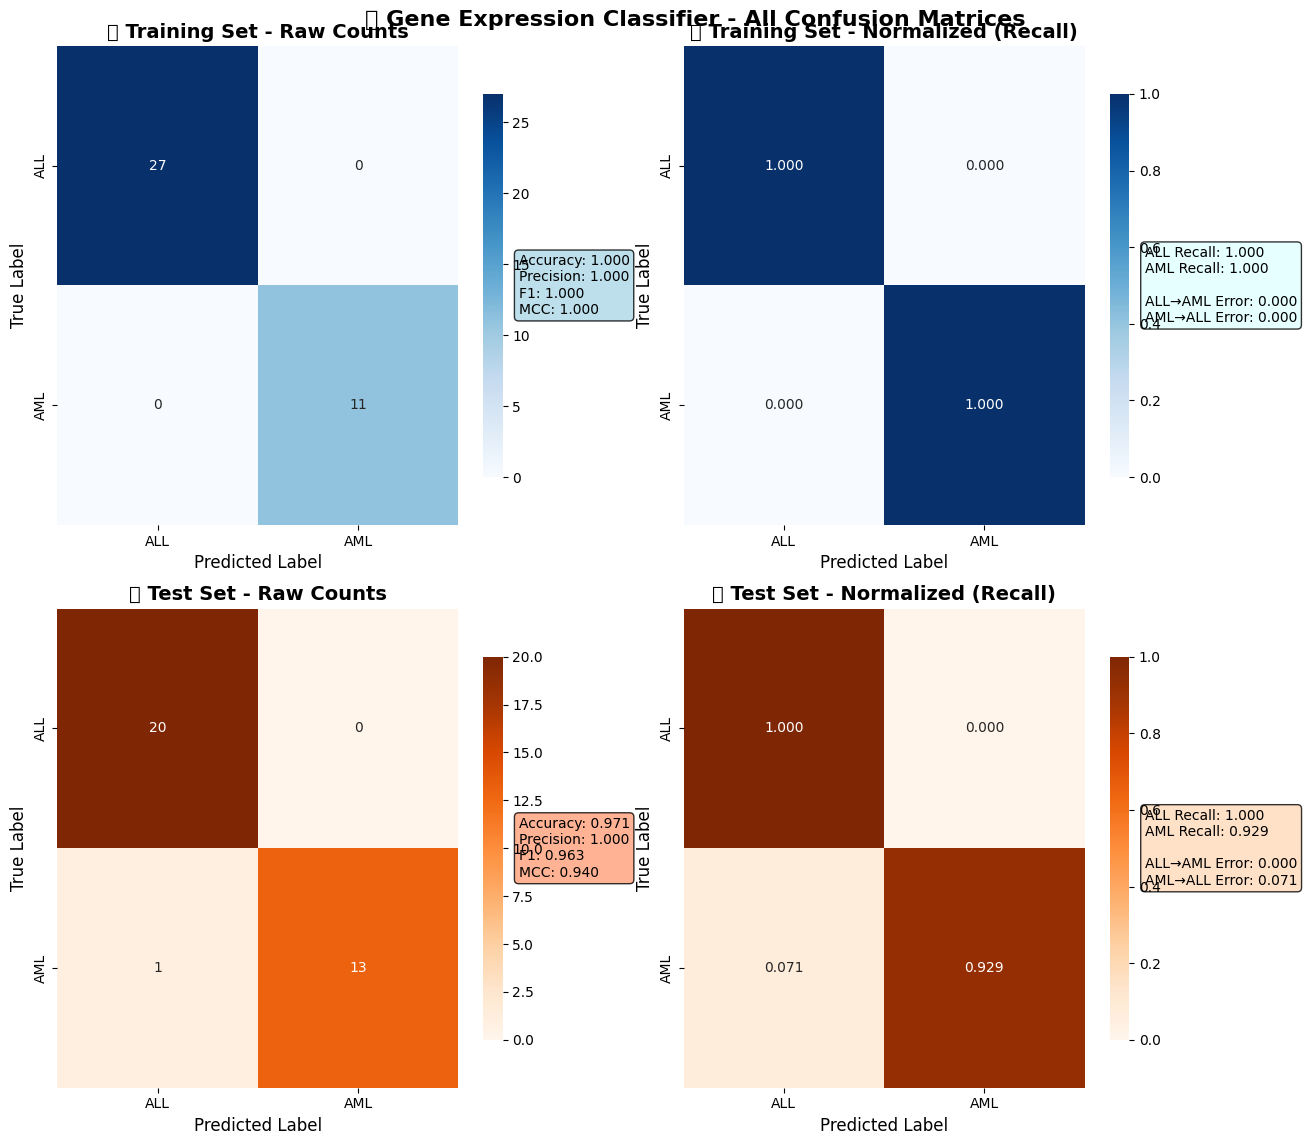


📊 CONFUSION MATRIX COMPARISON SUMMARY
                   Metric  Training   Test  Difference  % Change
 True Negatives (ALL→ALL)    27.000 20.000      -7.000   -25.900
False Positives (ALL→AML)     0.000  0.000       0.000       NaN
False Negatives (AML→ALL)     0.000  1.000       1.000       inf
 True Positives (AML→AML)    11.000 13.000       2.000    18.200
 ALL Recall (Sensitivity)     1.000  1.000       0.000     0.000
 AML Recall (Sensitivity)     1.000  0.929      -0.071    -7.100
            ALL Precision     1.000  0.952      -0.048    -4.800
            AML Precision     1.000  1.000       0.000     0.000
         Overall Accuracy     1.000  0.971      -0.029    -2.900

🔍 KEY INSIGHTS:
   • Training samples: 38 | Test samples: 34
   • Best generalization: ✅ Accuracy drop: 2.9%
   • ALL detection: Train=1.000 vs Test=1.000
   • AML detection: Train=1.000 vs Test=0.929
   • Most challenging: AML→ALL misclassification


In [36]:
# 5.2.6) All Confusion Matrices Together - Consolidated View
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🎯 CREATING CONSOLIDATED CONFUSION MATRICES VISUALIZATION")
print("=" * 60)

# Create a 2x2 subplot for all confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('🧬 Gene Expression Classifier - All Confusion Matrices', 
             fontsize=16, fontweight='bold', y=0.95)

# Calculate normalized versions
train_cm_norm = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]
test_cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 1. Training - Raw Confusion Matrix
ax1 = axes[0, 0]
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], 
            ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('🧪 Training Set - Raw Counts', fontweight='bold', fontsize=14)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Add performance metrics as text
train_text = f'Accuracy: {train_acc:.3f}\nPrecision: {train_prec:.3f}\nF1: {train_f1:.3f}\nMCC: {train_mcc:.3f}'
ax1.text(1.15, 0.5, train_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", 
         facecolor="lightblue", alpha=0.8))

# 2. Training - Normalized Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(train_cm_norm, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], 
            ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('🧪 Training Set - Normalized (Recall)', fontweight='bold', fontsize=14)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

# Add recall rates as text
train_recall_text = f'ALL Recall: {train_cm_norm[0,0]:.3f}\nAML Recall: {train_cm_norm[1,1]:.3f}\n\nALL→AML Error: {train_cm_norm[0,1]:.3f}\nAML→ALL Error: {train_cm_norm[1,0]:.3f}'
ax2.text(1.15, 0.5, train_recall_text, transform=ax2.transAxes, fontsize=10,
         verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", 
         facecolor="lightcyan", alpha=0.8))

# 3. Test - Raw Confusion Matrix
ax3 = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], 
            ax=ax3, cbar_kws={'shrink': 0.8})
ax3.set_title('🎯 Test Set - Raw Counts', fontweight='bold', fontsize=14)
ax3.set_xlabel('Predicted Label', fontsize=12)
ax3.set_ylabel('True Label', fontsize=12)

# Add performance metrics as text
test_text = f'Accuracy: {acc:.3f}\nPrecision: {prec:.3f}\nF1: {f1:.3f}\nMCC: {mcc:.3f}'
ax3.text(1.15, 0.5, test_text, transform=ax3.transAxes, fontsize=10,
         verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", 
         facecolor="lightsalmon", alpha=0.8))

# 4. Test - Normalized Confusion Matrix
ax4 = axes[1, 1]
sns.heatmap(test_cm_norm, annot=True, fmt='.3f', cmap='Oranges', 
            xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], 
            ax=ax4, cbar_kws={'shrink': 0.8})
ax4.set_title('🎯 Test Set - Normalized (Recall)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Predicted Label', fontsize=12)
ax4.set_ylabel('True Label', fontsize=12)

# Add recall rates as text
test_recall_text = f'ALL Recall: {test_cm_norm[0,0]:.3f}\nAML Recall: {test_cm_norm[1,1]:.3f}\n\nALL→AML Error: {test_cm_norm[0,1]:.3f}\nAML→ALL Error: {test_cm_norm[1,0]:.3f}'
ax4.text(1.15, 0.5, test_recall_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", 
         facecolor="peachpuff", alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, right=0.85)
plt.show()

# Create a summary comparison table
print("\n" + "="*80)
print("📊 CONFUSION MATRIX COMPARISON SUMMARY")
print("="*80)

# Create comparison DataFrame
comparison_data = {
    'Metric': ['True Negatives (ALL→ALL)', 'False Positives (ALL→AML)', 
               'False Negatives (AML→ALL)', 'True Positives (AML→AML)',
               'ALL Recall (Sensitivity)', 'AML Recall (Sensitivity)',
               'ALL Precision', 'AML Precision', 'Overall Accuracy'],
    'Training': [
        train_cm[0,0], train_cm[0,1], train_cm[1,0], train_cm[1,1],
        train_cm_norm[0,0], train_cm_norm[1,1],
        train_cm[0,0]/(train_cm[0,0]+train_cm[1,0]) if (train_cm[0,0]+train_cm[1,0]) > 0 else 0,
        train_cm[1,1]/(train_cm[0,1]+train_cm[1,1]) if (train_cm[0,1]+train_cm[1,1]) > 0 else 0,
        train_acc
    ],
    'Test': [
        cm[0,0], cm[0,1], cm[1,0], cm[1,1],
        test_cm_norm[0,0], test_cm_norm[1,1],
        cm[0,0]/(cm[0,0]+cm[1,0]) if (cm[0,0]+cm[1,0]) > 0 else 0,
        cm[1,1]/(cm[0,1]+cm[1,1]) if (cm[0,1]+cm[1,1]) > 0 else 0,
        acc
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Test'] - comparison_df['Training']
comparison_df['% Change'] = (comparison_df['Difference'] / comparison_df['Training'] * 100).round(1)

print(comparison_df.to_string(index=False, float_format='%.3f'))

print(f"\n🔍 KEY INSIGHTS:")
print(f"   • Training samples: {len(y_train)} | Test samples: {len(y_test)}")
print(f"   • Best generalization: {'✅' if abs(train_acc - acc) < 0.05 else '⚠️'} Accuracy drop: {(train_acc - acc)*100:.1f}%")
print(f"   • ALL detection: Train={train_cm_norm[0,0]:.3f} vs Test={test_cm_norm[0,0]:.3f}")
print(f"   • AML detection: Train={train_cm_norm[1,1]:.3f} vs Test={test_cm_norm[1,1]:.3f}")
print(f"   • Most challenging: {'ALL→AML' if max(train_cm_norm[0,1], test_cm_norm[0,1]) > max(train_cm_norm[1,0], test_cm_norm[1,0]) else 'AML→ALL'} misclassification")
print("="*80)

### 5.3 Visualize Results - Confusion Matrix Heatmap

🎨 CREATING CONFUSION MATRIX VISUALIZATION


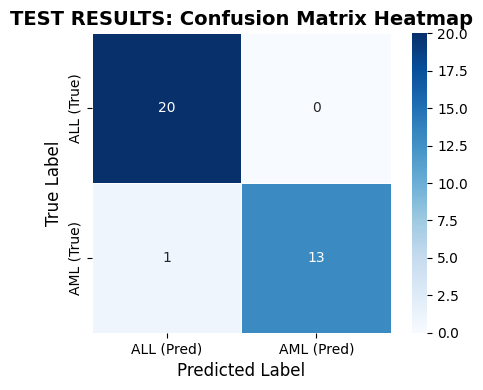

✅ Heatmap generated successfully!


In [37]:
# Create confusion matrix visualization
print("🎨 CREATING CONFUSION MATRIX VISUALIZATION")
print("=" * 45)

labels = ['ALL (True)','AML (True)']
pred_labels = ['ALL (Pred)','AML (Pred)']
cm_df = pd.DataFrame(cm, index=labels, columns=pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, 
            square=True, linewidths=0.5)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('TEST RESULTS: Confusion Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Heatmap generated successfully!")

### 5.4 Store Test Results

In [38]:
# Store all test metrics in dictionary for easy access
metrics = {
    'accuracy': acc,
    'precision': prec,
    'f1_score': f1,
    'mcc': mcc,
    'confusion_matrix': cm.tolist()
}

print("💾 TEST RESULTS STORED")
print("=" * 25)
print("📋 Final Test Performance Summary:")
print(f"   • Accuracy:  {metrics['accuracy']:.4f}")
print(f"   • Precision: {metrics['precision']:.4f}")
print(f"   • F1-Score:  {metrics['f1_score']:.4f}")
print(f"   • MCC:       {metrics['mcc']:.4f}")
print("\n🎯 TESTING PHASE COMPLETE!")
print("=" * 60)

💾 TEST RESULTS STORED
📋 Final Test Performance Summary:
   • Accuracy:  0.9706
   • Precision: 1.0000
   • F1-Score:  0.9630
   • MCC:       0.9404

🎯 TESTING PHASE COMPLETE!


## 6. Final Notes
- Independent test metrics reflect generalization.
- One false negative (AML predicted as ALL) drives F1 < 1.
- Adjust grid in Section 4 to explore other k or C ranges.
- The `metrics` dictionary (Section 5) holds raw numeric results.
- For persistence: you could add joblib dump after training.

In [39]:

# 6. Export Selected Genes
# Get the boolean mask from the 'select' step of the best pipeline
mask = best_model.named_steps['select'].get_support()

# Get the column names (gene accession numbers) from the training data
all_genes = X_train.columns

# Filter the gene names using the mask
selected_genes = all_genes[mask]

# Create a DataFrame to save to CSV
selected_genes_df = pd.DataFrame(selected_genes, columns=['Gene Accession Number'])

# Save the selected genes to a CSV file
output_path = DATA_DIR / 'selected_genes.csv'
selected_genes_df.to_csv(output_path, index=False)

print(f"Found {len(selected_genes)} selected genes. Saved to '{output_path}'")
print("\nSelected Genes (Accession Numbers):")
for gene in selected_genes:
    print(gene)


Found 25 selected genes. Saved to 'selected_genes.csv'

Selected Genes (Accession Numbers):
D49950_at
L08246_at
M11147_at
M16038_at
M23197_at
M27891_at
M55150_at
M57710_at
M62762_at
M63138_at
M80254_at
M84526_at
M96326_rna1_at
U12471_cds1_at
U46751_at
U50136_rna1_at
U82759_at
X17042_at
X95735_at
Y12670_at
M28130_rna1_s_at
Y00787_s_at
M81695_s_at
X85116_rna1_s_at
M19045_f_at
